In [1]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade fiona geopandas


Requirement already up-to-date: fiona in /opt/conda/lib/python3.8/site-packages (1.10.1)
Requirement already up-to-date: geopandas in /opt/conda/lib/python3.8/site-packages (0.13.2)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import contextily as ctx
from pyspark.sql import functions as F
import numpy as np
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import split


In [6]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession.builder.appName("project").getOrCreate()


# import data

In [7]:
df_2018 = spark.read.csv("hdfs://namenode:9000/Pedestrain_2018.csv", header=True, inferSchema=True)
df_2019 = spark.read.csv("hdfs://namenode:9000/Pedestrain_2019_(1).csv", header=True, inferSchema=True)
df_2020 = spark.read.csv("hdfs://namenode:9000/Pedestrain_2020.csv", header=True, inferSchema=True)
df_2021 = spark.read.csv("hdfs://namenode:9000/Pedestrain_2021.csv", header=True, inferSchema=True)
df_2022 = spark.read.csv("hdfs://namenode:9000/Pedestrain_2022.csv", header=True, inferSchema=True)

df_2023 = spark.read.csv("hdfs://namenode:9000/pedestrian_data_2023.csv", header=True, inferSchema=True)
df_2024 = spark.read.csv("hdfs://namenode:9000/pedestrian_data_2023.csv", header=True, inferSchema=True)

sensor = spark.read.csv("hdfs://namenode:9000/pedestrian-counting-system-sensor-locations.csv", header=True, inferSchema=True)


# 1. Data exploration and preprocessing

### 1.1View original data

In [8]:
df_2018.describe()


DataFrame[summary: string, ID: string, Date_Time: string, Year: string, Month: string, Mdate: string, Day: string, Time: string, Sensor_ID: string, Sensor_Name: string, Hourly_Counts: string]

In [9]:
columns = df_2018.columns
missing_values = df_2018.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in columns])

# check missing value
missing_values.show()

+---+---------+----+-----+-----+---+----+---------+-----------+-------------+
| ID|Date_Time|Year|Month|Mdate|Day|Time|Sensor_ID|Sensor_Name|Hourly_Counts|
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+
|  0|        0|   0|    0|    0|  0|   0|        0|          0|            0|
+---+---------+----+-----+-----+---+----+---------+-----------+-------------+



In [10]:
#differnet dataFrame
df_2024.describe()

DataFrame[summary: string, ID: string, Location_ID: string, Sensing_Date: string, HourDay: string, Direction_1: string, Direction_2: string, Total_of_Directions: string, Sensor_Name: string, Location: string, Year: string]

In [11]:
columns = df_2024.columns
missing_values = df_2024.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in columns])

# check missing value
missing_values.show()

+---+-----------+------------+-------+-----------+-----------+-------------------+-----------+--------+----+
| ID|Location_ID|Sensing_Date|HourDay|Direction_1|Direction_2|Total_of_Directions|Sensor_Name|Location|Year|
+---+-----------+------------+-------+-----------+-----------+-------------------+-----------+--------+----+
|  0|          0|           0|      0|          0|          0|                  0|          0|       0|   0|
+---+-----------+------------+-------+-----------+-----------+-------------------+-----------+--------+----+



In [12]:
sensor.describe()


DataFrame[summary: string, Location_ID: string, Sensor_Description: string, Sensor_Name: string, Installation_Date: string, Note: string, Location_Type: string, Status: string, Direction_1: string, Direction_2: string, Latitude: string, Longitude: string, Location: string]

In [13]:
columns = sensor.columns
missing_values = sensor.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in columns])
missing_values.show()

+-----------+------------------+-----------+-----------------+----+-------------+------+-----------+-----------+--------+---------+--------+
|Location_ID|Sensor_Description|Sensor_Name|Installation_Date|Note|Location_Type|Status|Direction_1|Direction_2|Latitude|Longitude|Location|
+-----------+------------------+-----------+-----------------+----+-------------+------+-----------+-----------+--------+---------+--------+
|          0|                 2|          0|                2| 108|            0|     0|         32|         32|       0|        0|       0|
+-----------+------------------+-----------+-----------------+----+-------------+------+-----------+-----------+--------+---------+--------+



### 1.2Retain useful data

In [14]:
#Retain useful data
df_2018_selected = df_2018.select("Year", "Month", "Mdate", "Day", "Time", "Sensor_Name", "Hourly_Counts")
df_2019_selected = df_2019.select("Year", "Month", "Mdate", "Day", "Time", "Sensor_Name", "Hourly_Counts")
df_2020_selected = df_2020.select("Year", "Month", "Mdate", "Day", "Time", "Sensor_Name", "Hourly_Counts")
df_2021_selected = df_2021.select("Year", "Month", "Mdate", "Day", "Time", "Sensor_Name", "Hourly_Counts")
df_2022_selected = df_2022.select("Year", "Month", "Mdate", "Day", "Time", "Sensor_Name", "Hourly_Counts")
df_2023_selected = df_2023.select("Location_ID","Sensing_Date","HourDay","Total_of_Directions","Sensor_Name","Location","Year"
)
df_2024_selected = df_2024.select("Location_ID","Sensing_Date","HourDay","Total_of_Directions","Sensor_Name","Location","Year"
)
sensor_selected = sensor.select("Location_ID","Sensor_Description","Installation_Date","Location_Type","Location")



Cleansing data
1.deal with missing data

In [15]:
#Cleansing data in pedestrain do nothing in sensor
median_hourly_counts_2018 = df_2018_selected.approxQuantile("Hourly_Counts", [0.5], 0.01)[0]
median_hourly_counts_2019 = df_2019_selected.approxQuantile("Hourly_Counts", [0.5], 0.01)[0]
median_hourly_counts_2020 = df_2020_selected.approxQuantile("Hourly_Counts", [0.5], 0.01)[0]
median_hourly_counts_2021 = df_2021_selected.approxQuantile("Hourly_Counts", [0.5], 0.01)[0]
median_hourly_counts_2022 = df_2022_selected.approxQuantile("Hourly_Counts", [0.5], 0.01)[0]
df_2018_clean = df_2018_selected.fillna({'Hourly_Counts': median_hourly_counts_2018})
df_2019_clean = df_2019_selected.fillna({'Hourly_Counts': median_hourly_counts_2019})
df_2020_clean = df_2020_selected.fillna({'Hourly_Counts': median_hourly_counts_2020})
df_2021_clean = df_2021_selected.fillna({'Hourly_Counts': median_hourly_counts_2021})
df_2022_clean = df_2022_selected.fillna({'Hourly_Counts': median_hourly_counts_2022})

from pyspark.sql.functions import date_format, dayofweek, when

# separate month and data
df_2023_selected = df_2023_selected.withColumn("Month", date_format("Sensing_Date", "M")) \
                                   .withColumn("Mdate", date_format("Sensing_Date", "d"))

df_2024_selected = df_2024_selected.withColumn("Month", date_format("Sensing_Date", "M")) \
                                   .withColumn("Mdate", date_format("Sensing_Date", "d"))

# accroding Sensing_Date to identify day
df_2023_selected = df_2023_selected.withColumn("Day", 
    when(dayofweek("Sensing_Date") == 1, "Sunday")
    .when(dayofweek("Sensing_Date") == 2, "Monday")
    .when(dayofweek("Sensing_Date") == 3, "Tuesday")
    .when(dayofweek("Sensing_Date") == 4, "Wednesday")
    .when(dayofweek("Sensing_Date") == 5, "Thursday")
    .when(dayofweek("Sensing_Date") == 6, "Friday")
    .when(dayofweek("Sensing_Date") == 7, "Saturday")
)

df_2024_selected = df_2024_selected.withColumn("Day", 
    when(dayofweek("Sensing_Date") == 1, "Sunday")
    .when(dayofweek("Sensing_Date") == 2, "Monday")
    .when(dayofweek("Sensing_Date") == 3, "Tuesday")
    .when(dayofweek("Sensing_Date") == 4, "Wednesday")
    .when(dayofweek("Sensing_Date") == 5, "Thursday")
    .when(dayofweek("Sensing_Date") == 6, "Friday")
    .when(dayofweek("Sensing_Date") == 7, "Saturday")
)

#Delete the Sensing-Date column and rename Total_of_Directions to Houryly_Counts, HourDay rename to Time
df_2023_clean = df_2023_selected.drop("Sensing_Date") \
                                   .withColumnRenamed("Total_of_Directions", "Hourly_Counts")\
                                   .withColumnRenamed("HourDay", "Time")

df_2024_clean = df_2024_selected.drop("Sensing_Date") \
                                   .withColumnRenamed("Total_of_Directions", "Hourly_Counts")\
                                   .withColumnRenamed("HourDay", "Time")




In [16]:
df_2024_clean.describe()

DataFrame[summary: string, Location_ID: string, Time: string, Hourly_Counts: string, Sensor_Name: string, Location: string, Year: string, Month: string, Mdate: string, Day: string]

###  1.3detail overview of database

####  sensor

In [17]:
sensor_with_year = sensor.withColumn("installation_year", F.year("Installation_Date"))
sensor_grouped_by_year = sensor_with_year.groupBy("installation_year").count()
sensor_grouped_by_year.show()


+-----------------+-----+
|installation_year|count|
+-----------------+-----+
|             2018|    9|
|             2015|   14|
|             2023|   27|
|             2022|    6|
|             2013|   13|
|             null|    2|
|             2019|    6|
|             2020|   11|
|             2009|   18|
|             2016|    1|
|             2024|   14|
|             2017|    9|
|             2021|   11|
+-----------------+-----+



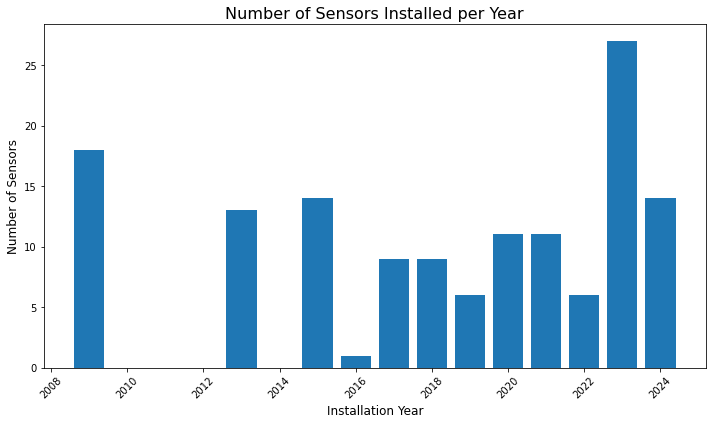

In [18]:
sensor_grouped_by_year_pd = sensor_grouped_by_year.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(sensor_grouped_by_year_pd['installation_year'], sensor_grouped_by_year_pd['count'])

plt.title("Number of Sensors Installed per Year", fontsize=16)
plt.xlabel("Installation Year", fontsize=12)
plt.ylabel("Number of Sensors", fontsize=12)

plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

#### pedestrain

In [19]:
df_2018_clean_pd = df_2018_clean.toPandas()
df_2019_clean_pd = df_2019_clean.toPandas()
df_2020_clean_pd = df_2020_clean.toPandas()
df_2021_clean_pd = df_2021_clean.toPandas()
df_2022_clean_pd = df_2022_clean.toPandas()
df_2023_clean_pd = df_2023_clean.toPandas()
df_2024_clean_pd = df_2024_clean.toPandas()




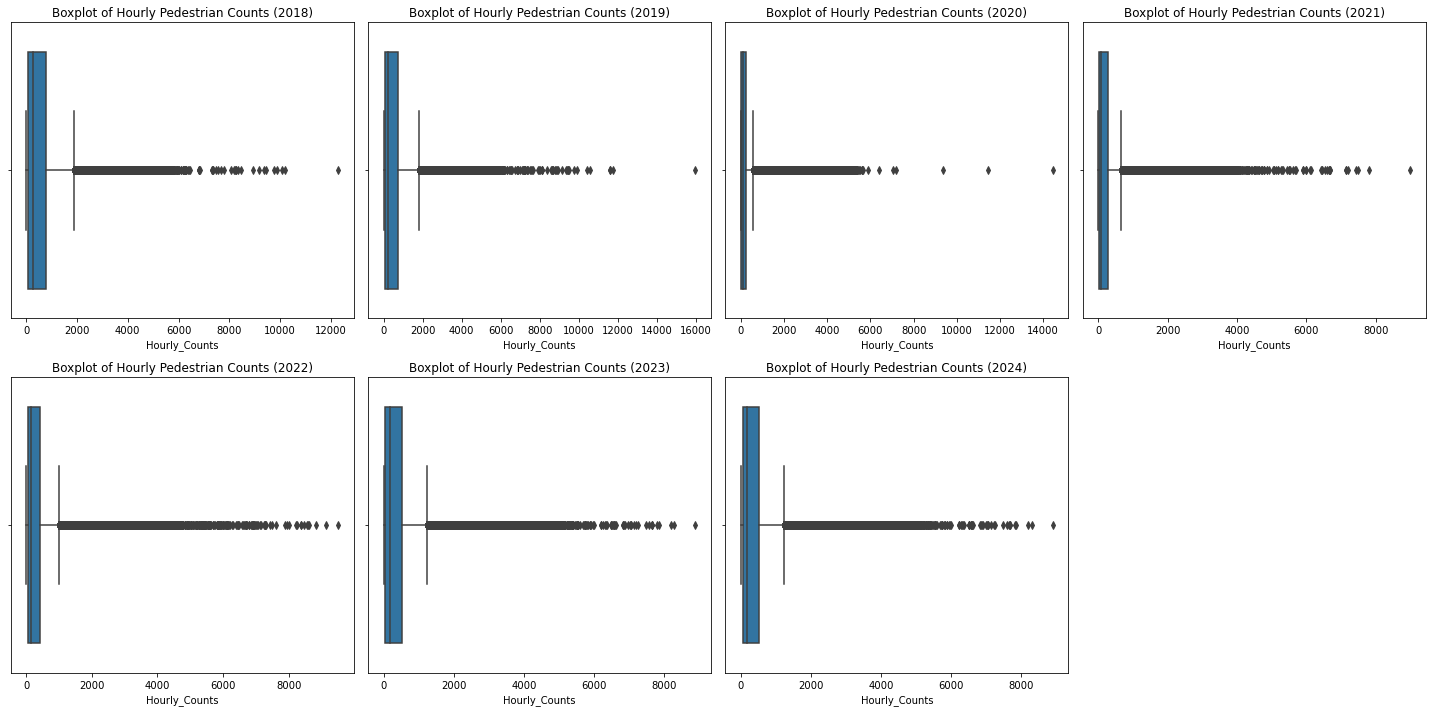

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 4, figsize=(20, 10))  

sns.boxplot(x=df_2018_clean_pd['Hourly_Counts'], ax=axs[0, 0])
axs[0, 0].set_title('Boxplot of Hourly Pedestrian Counts (2018)')

sns.boxplot(x=df_2019_clean_pd['Hourly_Counts'], ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of Hourly Pedestrian Counts (2019)')

sns.boxplot(x=df_2020_clean_pd['Hourly_Counts'], ax=axs[0, 2])
axs[0, 2].set_title('Boxplot of Hourly Pedestrian Counts (2020)')

sns.boxplot(x=df_2021_clean_pd['Hourly_Counts'], ax=axs[0, 3])
axs[0, 3].set_title('Boxplot of Hourly Pedestrian Counts (2021)')

sns.boxplot(x=df_2022_clean_pd['Hourly_Counts'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot of Hourly Pedestrian Counts (2022)')

sns.boxplot(x=df_2023_clean_pd['Hourly_Counts'], ax=axs[1, 1])
axs[1, 1].set_title('Boxplot of Hourly Pedestrian Counts (2023)')

sns.boxplot(x=df_2024_clean_pd['Hourly_Counts'], ax=axs[1, 2])
axs[1, 2].set_title('Boxplot of Hourly Pedestrian Counts (2024)')

fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.show()


# 2.Spark sql and chart

### create Temporary View

In [21]:
df_2018_clean.createOrReplaceTempView("2018_Pedestrain")
df_2019_clean.createOrReplaceTempView("2019_Pedestrain")
df_2020_clean.createOrReplaceTempView("2020_Pedestrain")
df_2021_clean.createOrReplaceTempView("2021_Pedestrain")
df_2022_clean.createOrReplaceTempView("2022_Pedestrain")
df_2023_clean.createOrReplaceTempView("2023_Pedestrain")
df_2024_clean.createOrReplaceTempView("2024_Pedestrain")

sensor_selected.createOrReplaceTempView("sensor_view")

In [22]:
#Connect 2023-Pedetrain and sensor-view
query_2023 = """
SELECT p.Location_ID, p.Year, p.Month, p.Mdate, p.Day, p.Time, p.Sensor_Name, p.Hourly_Counts, p.Location, 
       s.Sensor_Description, s.Installation_Date, s.Location_Type
FROM 2023_Pedestrain p
LEFT JOIN sensor_view s ON p.Location_ID = s.Location_ID
"""

df_2023_PedSensor = spark.sql(query_2023)

#Connect 2024-Pedetrain and sensor-view
query_2024 = """
SELECT p.Location_ID, p.Year, p.Month, p.Mdate, p.Day, p.Time, p.Sensor_Name, p.Hourly_Counts, p.Location, 
       s.Sensor_Description, s.Installation_Date, s.Location_Type
FROM 2024_Pedestrain p
LEFT JOIN sensor_view s ON p.Location_ID = s.Location_ID
"""

df_2024_PedSensor = spark.sql(query_2024)

df_2023_PedSensor.createOrReplaceTempView("2023_PedSensor")
df_2024_PedSensor.createOrReplaceTempView("2024_PedSensor")


## 2.1：Sensor query and visualization of the top 3 total pedestrian flow in different years

### 2018-2022Search for the top 3 sensor information in terms of foot traffic

In [23]:
# Obtain the names of the top 3 sensors and their total passenger flow
top_sensors_query = """
SELECT p.Sensor_Name, SUM(p.Hourly_Counts) as Total_Hourly_Counts
FROM (
    SELECT * FROM 2018_Pedestrain
    UNION ALL
    SELECT * FROM 2019_Pedestrain
    UNION ALL
    SELECT * FROM 2020_Pedestrain
    UNION ALL
    SELECT * FROM 2021_Pedestrain
    UNION ALL
    SELECT * FROM 2022_Pedestrain
) p
GROUP BY p.Sensor_Name
ORDER BY Total_Hourly_Counts DESC
LIMIT 3
"""

top_sensors_df = spark.sql(top_sensors_query)
top_sensors_df.createOrReplaceTempView("top_sensors")

top_sensors_df.show()

+--------------------+-------------------+
|         Sensor_Name|Total_Hourly_Counts|
+--------------------+-------------------+
|           Southbank|           45508477|
|Flinders La-Swans...|           41479691|
|    Town Hall (West)|           40940195|
+--------------------+-------------------+



In [24]:
#Connect sensor-view to obtain Location information
sensors_location_query = """
SELECT ts.Sensor_Name, ts.Total_Hourly_Counts, sv.Location
FROM top_sensors ts
LEFT JOIN sensor_view sv ON ts.Sensor_Name = sv.Sensor_Description
"""

sensors_location_df = spark.sql(sensors_location_query)

sensors_location_df.show()


+--------------------+-------------------+--------------------+
|         Sensor_Name|Total_Hourly_Counts|            Location|
+--------------------+-------------------+--------------------+
|           Southbank|           45508477|-37.82017828, 144...|
|Flinders La-Swans...|           41479691|-37.81668634, 144...|
|    Town Hall (West)|           40940195|-37.81487988, 144...|
+--------------------+-------------------+--------------------+



### 2023-2024Search for the top 3 sensor information in terms of foot traffic

In [25]:
#Search for the top 3 sensors with passenger flow in 2023 and 2024
top_2324_query = """
SELECT Sensor_Description, Location, SUM(Hourly_Counts) AS Total_Counts
FROM (
    SELECT Sensor_Description, Location, Hourly_Counts
    FROM 2023_PedSensor
    UNION ALL
    SELECT Sensor_Description, Location, Hourly_Counts
    FROM 2024_PedSensor
)
GROUP BY Sensor_Description, Location
ORDER BY Total_Counts DESC
LIMIT 3
"""

top_2324_df = spark.sql(top_2324_query)

top_2324_df.show()

+--------------------+--------------------+------------+
|  Sensor_Description|            Location|Total_Counts|
+--------------------+--------------------+------------+
|   Melbourne Central|-37.81101524, 144...|    39757602|
|Flinders La-Swans...|-37.81668634, 144...|    28050384|
|           Southbank|-37.82017828, 144...|    25848554|
+--------------------+--------------------+------------+



In [26]:
sensors_location_pandas = sensors_location_df.toPandas()
top_2324_pandas = top_2324_df.toPandas()

melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)


# Add a red mark to sensor from top3 of 2018-2022
for _, row in sensors_location_pandas.iterrows():
    lat, lon = map(float, row['Location'].split(','))
    popup_text = f"{row['Sensor_Name']}: {row['Total_Hourly_Counts']} counts"
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color='red')
    ).add_to(melbourne_map)


# Add a blue mark to sensor from top3 of 2023-2024
for _, row in top_2324_pandas.iterrows():
    lat, lon = map(float, row['Location'].split(','))
    popup_text = f"{row['Sensor_Description']}: {row['Total_Counts']} counts"
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color='blue')
    ).add_to(melbourne_map)

melbourne_map


It can be seen from the data and maps that the area around Flinders Street train station and the Melbourne Central business district are key transportation and business hubs in Melbourne. Even if affected by the epidemic, the flow of people remains high.
Southbank's location remains at the top despite falling in the rankings, reflecting the area's continued appeal for city living.

## 2.2:Draw a line chart to calculate the daily passenger flow from 2018 to 2024 on a daily basis

In [27]:
# Merge data from 2018 to 2024 and calculate daily passenger flow
query_daily_traffic = """
SELECT Year, Month, Mdate AS Day, SUM(Hourly_Counts) AS Total_Count
FROM (
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2018_Pedestrain
    UNION ALL
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2019_Pedestrain
    UNION ALL
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2020_Pedestrain
    UNION ALL
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2021_Pedestrain
    UNION ALL
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2022_Pedestrain
    UNION ALL
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2023_Pedestrain
    UNION ALL
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2024_Pedestrain
) AS combined_data
GROUP BY Year, Month, Day
ORDER BY Year, Month, Day
"""

daily_traffic = spark.sql(query_daily_traffic)
daily_traffic.show()


+----+-----+---+-----------+
|Year|Month|Day|Total_Count|
+----+-----+---+-----------+
|2018|April|  1|     650146|
|2018|April| 10|     823252|
|2018|April| 11|     843341|
|2018|April| 12|     838379|
|2018|April| 13|     945614|
|2018|April| 14|     597581|
|2018|April| 15|     531138|
|2018|April| 16|     702178|
|2018|April| 17|     783506|
|2018|April| 18|     797086|
|2018|April| 19|     814806|
|2018|April|  2|     583467|
|2018|April| 20|     917216|
|2018|April| 21|     760740|
|2018|April| 22|     625226|
|2018|April| 23|     727523|
|2018|April| 24|     798050|
|2018|April| 25|     684714|
|2018|April| 26|     749539|
|2018|April| 27|     827569|
+----+-----+---+-----------+
only showing top 20 rows



In [28]:

month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}

daily_traffic_pd = daily_traffic.toPandas()

daily_traffic_pd['Month'] = daily_traffic_pd['Month'].replace(month_mapping)

daily_traffic_pd['Date'] = pd.to_datetime(daily_traffic_pd[['Year', 'Month', 'Day']])
daily_traffic_pd = daily_traffic_pd.sort_values(by='Date')

top_200_days = daily_traffic_pd.nlargest(200, 'Total_Count')

daily_traffic_pd['Is_Top_200'] = daily_traffic_pd['Date'].isin(top_200_days['Date'])


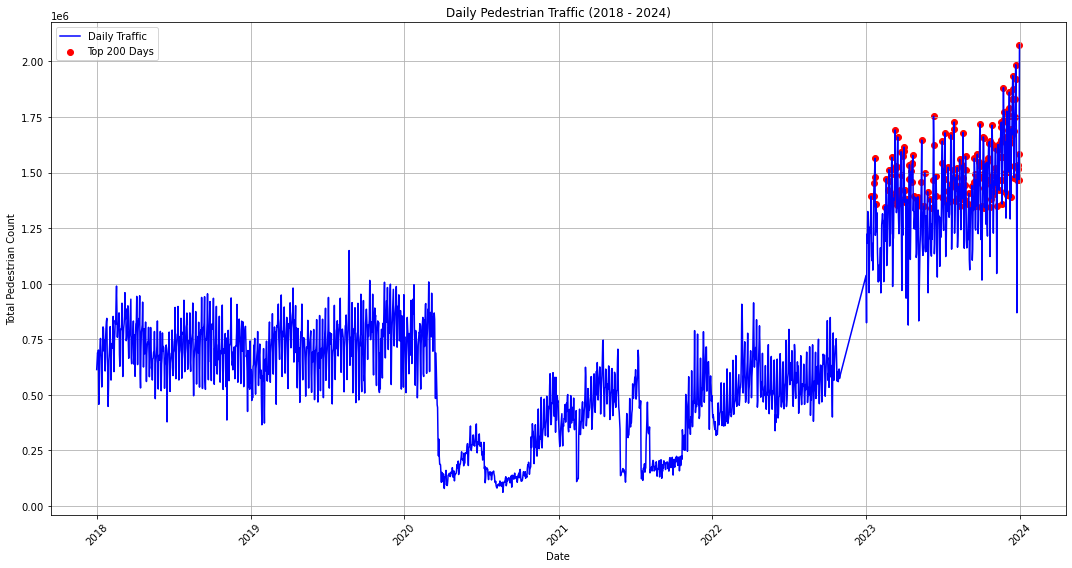

In [29]:

plt.figure(figsize=(15, 8))
plt.plot(daily_traffic_pd['Date'], daily_traffic_pd['Total_Count'], label='Daily Traffic', color='blue')

plt.scatter(top_200_days['Date'], top_200_days['Total_Count'], color='red', label='Top 200 Days')

plt.title('Daily Pedestrian Traffic (2018 - 2024)')
plt.xlabel('Date')
plt.ylabel('Total Pedestrian Count')
plt.legend()

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Before the epidemic (2018-2019): Pedestrian flow was generally relatively stable, with normal seasonal fluctuations, and urban activities were busy.
During the epidemic (2020-2021): Pedestrian traffic dropped sharply and showed lower volatility, reflecting the severe impact of the epidemic on public travel.
Post-pandemic (2022-2024): Pedestrian traffic gradually recovers, especially in 2023, with a significant upward trend. Peak day markers in 2023 and 2024 suggest that cities have rejuvenated and are returning to pre-pandemic and even higher footfall levels.

## 2.3: The average daily passenger flow from 2018 to 2019 before the epidemic, the average daily passenger flow in 2020 during the epidemic, and the average daily passenger flow after the epidemic (2023) are divided into three categories and displayed as three lines on a graph. The horizontal axis represents the date of the year, and the vertical axis represents the passenger flow


In [30]:
#Query the average hourly passenger flow before the epidemic (2018-2019)
query_pre_pandemic = """
SELECT Month, Mdate, AVG(Hourly_Counts) AS Avg_Daily_Count
FROM (
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2018_Pedestrain
    UNION ALL
    SELECT Year, Month, Mdate, Hourly_Counts FROM 2019_Pedestrain
) AS combined_data
GROUP BY Month, Mdate
ORDER BY Month, Mdate
"""

#Query the average hourly passenger flow in the epidemic year (2020)
query_pandemic = """
SELECT Month, Mdate, AVG(Hourly_Counts) AS Avg_Daily_Count
FROM 2020_Pedestrain
GROUP BY Month, Mdate
ORDER BY Month, Mdate;
"""

#Query the average hourly passenger flow after the epidemic (2023)
query_post_pandemic = """
SELECT Month, Mdate, AVG(Hourly_Counts) AS Avg_Daily_Count
FROM 2023_Pedestrain
GROUP BY Month, Mdate
ORDER BY Month, Mdate;
"""

pre_pandemic_df = spark.sql(query_pre_pandemic).toPandas()
pandemic_df = spark.sql(query_pandemic).toPandas()
post_pandemic_df = spark.sql(query_post_pandemic).toPandas()


In [31]:
pre_pandemic_df['Date'] = pd.to_datetime("2020-" + pre_pandemic_df['Month'].astype(str) + "-" + pre_pandemic_df['Mdate'].astype(str), errors='coerce')
pandemic_df['Date'] = pd.to_datetime("2020-" + pandemic_df['Month'].astype(str) + "-" + pandemic_df['Mdate'].astype(str), errors='coerce')
post_pandemic_df['Date'] = pd.to_datetime("2020-" + post_pandemic_df['Month'].astype(str) + "-" + post_pandemic_df['Mdate'].astype(str), errors='coerce')

pre_pandemic_df = pre_pandemic_df.sort_values(by='Date')
pandemic_df = pandemic_df.sort_values(by='Date')
post_pandemic_df = post_pandemic_df.sort_values(by='Date')


In [32]:
top_30_pre = pre_pandemic_df.nlargest(30, 'Avg_Daily_Count')
top_30_pandemic = pandemic_df.nlargest(30, 'Avg_Daily_Count')
top_30_post = post_pandemic_df.nlargest(30, 'Avg_Daily_Count')

pre_pandemic_df['Is_Top_30'] = pre_pandemic_df['Date'].isin(top_30_pre['Date'])
pandemic_df['Is_Top_30'] = pandemic_df['Date'].isin(top_30_pandemic['Date'])
post_pandemic_df['Is_Top_30'] = post_pandemic_df['Date'].isin(top_30_post['Date'])


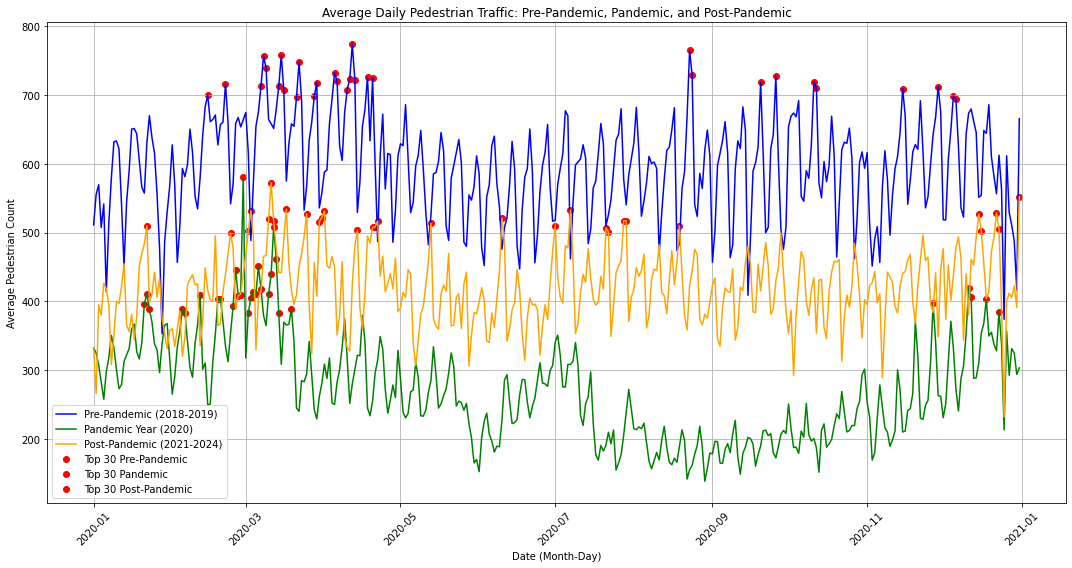

In [33]:


plt.figure(figsize=(15, 8))

plt.plot(pre_pandemic_df['Date'], pre_pandemic_df['Avg_Daily_Count'], label='Pre-Pandemic (2018-2019)', color='blue')
plt.scatter(top_30_pre['Date'], top_30_pre['Avg_Daily_Count'], color='red', label='Top 30 Pre-Pandemic')

plt.plot(pandemic_df['Date'], pandemic_df['Avg_Daily_Count'], label='Pandemic Year (2020)', color='green')
plt.scatter(top_30_pandemic['Date'], top_30_pandemic['Avg_Daily_Count'], color='red', label='Top 30 Pandemic')

plt.plot(post_pandemic_df['Date'], post_pandemic_df['Avg_Daily_Count'], label='Post-Pandemic (2023)', color='orange')
plt.scatter(top_30_post['Date'], top_30_post['Avg_Daily_Count'], color='red', label='Top 30 Post-Pandemic')

plt.title('Average Daily Pedestrian Traffic: Pre-Pandemic, Pandemic, and Post-Pandemic')
plt.xlabel('Date (Month-Day)')
plt.ylabel('Average Pedestrian Count')
plt.legend()

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


From this picture, we can see the average daily pedestrian flow in Melbourne before the epidemic (2018-2019), during the epidemic year (2020), and after the epidemic (2023). Combined with Melbourne’s legal and social background during the epidemic, we can conduct the following insightful analysis:
1. Before the epidemic (2018-2019)
The blue line represents the average daily pedestrian flow before the epidemic (2018-2019). You can see that the fluctuations throughout the year are very obvious, showing typical highs and lows between weekdays and weekends, as well as peaks during holidays.
These peak points (red marks) tend to occur during holidays and events, such as Christmas and New Year's Day at the end of the year, as well as various festivals and sporting events. This shows that Melbourne was very socially active before the epidemic, especially during these important festivals, when pedestrian traffic was higher.
Seasonal fluctuations: Melbourne's pedestrian traffic shows seasonal increases, particularly in the warmer spring and summer months (roughly October to February), which also reflects an increase in outdoor activities and festival celebrations.
2. The year of the epidemic (2020)
The green line shows average daily pedestrian traffic in 2020, the year of the pandemic, which is clearly a huge gap from pre-pandemic levels. Pedestrian traffic drops significantly throughout the year, especially between March and October, where it remains almost at a low level.
Why: This trend can be directly linked to the strict lockdown measures Melbourne implemented in 2020. Since the end of March, Victoria (the state where Melbourne is located) has announced a comprehensive stay-at-home policy, with non-essential commercial places closed and residents asked to reduce going out. Multiple lockdown phases have left public spaces virtually devoid of pedestrian activity.
Occasional spikes: Although overall traffic is low, you will still see slight spikes at certain points in time, which may be due to specific relaxations (such as short-term easing of restrictions), or some residents while shopping and essential travel Activity.
3. After the epidemic (2023)
The orange line represents average daily pedestrian traffic in 2023, which is up compared to the pre-pandemic blue line but is still below pre-pandemic levels. This reflects that although life gradually returns to normal after the epidemic, some changes may have occurred in residents’ travel behavior.
The emergence of a new trend: Even without government-mandated lockdowns, people will remain more cautious after the epidemic, which may lead to a slow recovery in pedestrian traffic. The growth of online shopping, the spread of working from home and shifts in certain business models could all lead to fewer pedestrians on Melbourne's streets. In addition, the economic recovery after the epidemic will also affect people’s consumption habits and travel frequency.
The peak points marked in red show that even in 2023, Melbourne will still have some holidays and important events that will attract a large number of people. For example, during the summer and year-end holidays, passenger traffic still increases significantly, which shows that urban life and activities are gradually recovering, but there is still a significant increase in passenger flow. It has not fully returned to the level of activity before the epidemic.

## 2.4 Calculate the top 10 sensor locations for daily and weekend foot traffic from 2023 to 2024

In [34]:
#Search for the top 10 Locations with the highest average daily passenger flow from 2023 to 2024
query_weekdays_top10 = """
SELECT p.Location_ID, s.Sensor_Description, AVG(p.Hourly_Counts) AS Avg_Workday_Count,p.Location
FROM (
    SELECT * FROM 2023_Pedestrain WHERE Day IN ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
    UNION ALL
    SELECT * FROM 2024_Pedestrain WHERE Day IN ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
) AS p
LEFT JOIN sensor_view s ON p.Location_ID = s.Location_ID
GROUP BY p.Location_ID, s.Sensor_Description,p.Location
ORDER BY Avg_Workday_Count DESC
LIMIT 10
"""

#Search for the top 10 Locations with the average weekend passenger flow for 2023-2024
query_weekends_top10 = """
SELECT p.Location_ID, s.Sensor_Description, AVG(p.Hourly_Counts) AS Avg_Weekend_Count,p.Location
FROM (
    SELECT * FROM 2023_Pedestrain WHERE Day IN ('Saturday', 'Sunday')
    UNION ALL
    SELECT * FROM 2024_Pedestrain WHERE Day IN ('Saturday', 'Sunday')
) AS p
LEFT JOIN sensor_view s ON p.Location_ID = s.Location_ID
GROUP BY p.Location_ID, s.Sensor_Description, p.Location
ORDER BY Avg_Weekend_Count DESC
LIMIT 10
"""

top10_weekdays = spark.sql(query_weekdays_top10).toPandas()
top10_weekends = spark.sql(query_weekends_top10).toPandas()


In [35]:

top10_weekdays[['Latitude', 'Longitude']] = top10_weekdays['Location'].str.split(',', expand=True).astype(float)
top10_weekends[['Latitude', 'Longitude']] = top10_weekends['Location'].str.split(',', expand=True).astype(float)


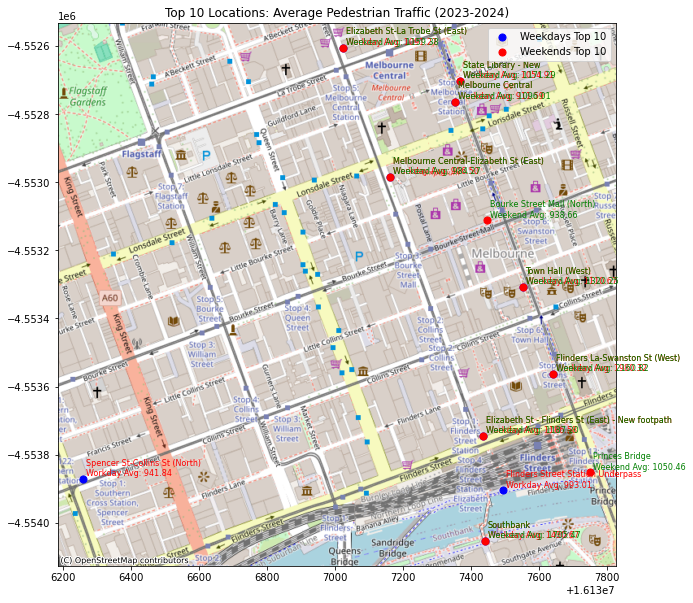

In [36]:

top10_weekdays['geometry'] = top10_weekdays.apply(lambda row: Point((float(row['Longitude']), float(row['Latitude']))), axis=1)
top10_weekends['geometry'] = top10_weekends.apply(lambda row: Point((float(row['Longitude']), float(row['Latitude']))), axis=1)

gdf_weekdays = gpd.GeoDataFrame(top10_weekdays, geometry='geometry', crs="EPSG:4326")
gdf_weekends = gpd.GeoDataFrame(top10_weekends, geometry='geometry', crs="EPSG:4326")

gdf_weekdays = gdf_weekdays.to_crs(epsg=3857)
gdf_weekends = gdf_weekends.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

#Draw workday points in blue

gdf_weekdays.plot(ax=ax, marker='o', color='blue', markersize=50, label='Weekdays Top 10')

#Draw weekend points (red)
gdf_weekends.plot(ax=ax, marker='o', color='red', markersize=50, label='Weekends Top 10')

for idx, row in gdf_weekdays.iterrows():
    ax.annotate(f"{row['Sensor_Description']}\nWorkday Avg: {row['Avg_Workday_Count']:.2f}", 
                xy=(row['geometry'].x, row['geometry'].y), 
                xytext=(3, 3), textcoords="offset points", color='red', fontsize=8)

for idx, row in gdf_weekends.iterrows():
    ax.annotate(f"{row['Sensor_Description']}\nWeekend Avg: {row['Avg_Weekend_Count']:.2f}", 
                xy=(row['geometry'].x, row['geometry'].y), 
                xytext=(3, 3), textcoords="offset points", color='green', fontsize=8)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Top 10 Locations: Average Pedestrian Traffic (2023-2024)')
plt.legend()

plt.show()


### Compare the top ten sensors in terms of foot traffic on weekdays and weekends

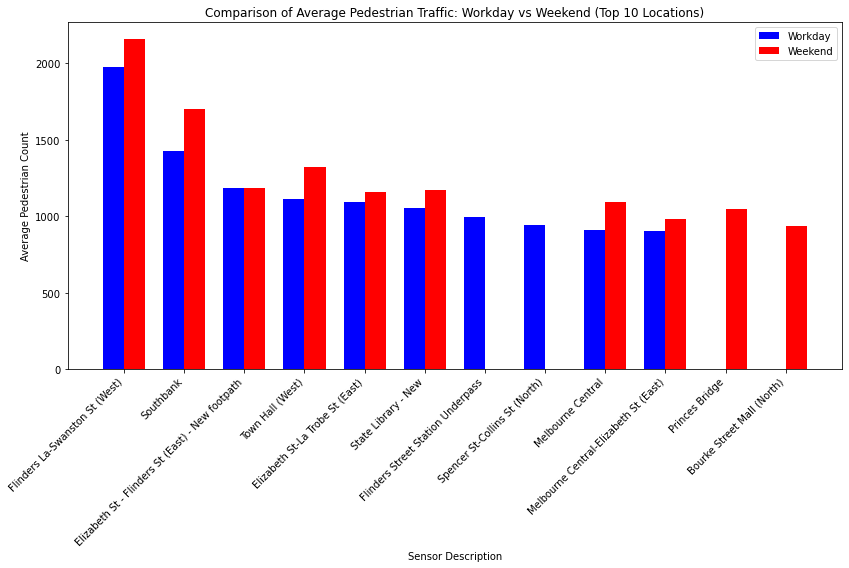

In [37]:
# 首先将两个 DataFrame 按 Location_ID 和 Sensor_Description 合并
merged_df = top10_weekdays[['Location_ID', 'Sensor_Description', 'Avg_Workday_Count']].merge(
    top10_weekends[['Location_ID', 'Sensor_Description', 'Avg_Weekend_Count']],
    on=['Location_ID', 'Sensor_Description'],
    how='outer'
)

# 用 0 填充 NaN 值（如果某些传感器在其中一个分类缺失）
merged_df.fillna(0, inplace=True)

import matplotlib.pyplot as plt
import numpy as np

# 设置图表大小和位置
fig, ax = plt.subplots(figsize=(12, 8))

# 定义 X 轴位置
x = np.arange(len(merged_df['Sensor_Description']))

# 设置柱状图的宽度
width = 0.35

# 绘制工作日和周末的柱状图
rects1 = ax.bar(x - width/2, merged_df['Avg_Workday_Count'], width, label='Workday', color='blue')
rects2 = ax.bar(x + width/2, merged_df['Avg_Weekend_Count'], width, label='Weekend', color='red')

# 添加标签和标题
ax.set_xlabel('Sensor Description')
ax.set_ylabel('Average Pedestrian Count')
ax.set_title('Comparison of Average Pedestrian Traffic: Workday vs Weekend (Top 10 Locations)')
ax.set_xticks(x)
ax.set_xticklabels(merged_df['Sensor_Description'], rotation=45, ha="right")
ax.legend()

# 显示柱状图
plt.tight_layout()
plt.show()


Peak commute weekday locations:
Flinders La-Swanston St (West), Town Hall (West), State Library-New show significantly higher footfall during weekdays and these areas are likely to be close to offices or public transport hubs and are typical commuting routes.
These locations are surrounded by high-rise buildings, office towers and bus stops, creating densely populated areas during peak workday hours.
Weekend peaks for leisure and shopping centers:
Southbank, Melbourne Central, Princes Bridge and Bourke Street Mall (North) showed high weekend footfalls. These locations are close to tourist attractions, shopping malls and shopping districts and are popular areas for shopping, leisure and dining on weekends.
Bourke Street Mall in particular is the centerpiece of the shopping district and attracts a large number of tourists and local residents on weekends.

## 2.5 Key analysis of specific information on sensors with significant differences in foot traffic between weekends and workdays

#### Using Spark SQL to query the average daily foot traffic of sensors at Flinders Street Station Underpass for one week from 2023 to 2024

In [38]:
query_weekly_avg = """
SELECT Day, AVG(Hourly_Counts) AS Avg_Daily_Count
FROM (
    SELECT Day, Hourly_Counts FROM 2023_PedSensor WHERE Sensor_Description = 'Flinders Street Station Underpass'
    UNION ALL
    SELECT Day, Hourly_Counts FROM 2024_PedSensor WHERE Sensor_Description = 'Flinders Street Station Underpass'
) AS combined_data
GROUP BY Day
ORDER BY 
    CASE 
        WHEN Day = 'Monday' THEN 1
        WHEN Day = 'Tuesday' THEN 2
        WHEN Day = 'Wednesday' THEN 3
        WHEN Day = 'Thursday' THEN 4
        WHEN Day = 'Friday' THEN 5
        WHEN Day = 'Saturday' THEN 6
        WHEN Day = 'Sunday' THEN 7
    END
"""

weekly_avg_df = spark.sql(query_weekly_avg).toPandas()


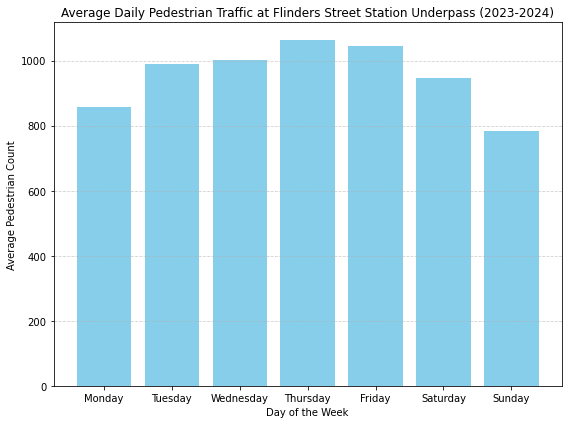

In [39]:

plt.figure(figsize=(8, 6))

plt.bar(weekly_avg_df['Day'], weekly_avg_df['Avg_Daily_Count'], color='skyblue')
plt.title('Average Daily Pedestrian Traffic at Flinders Street Station Underpass (2023-2024)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Pedestrian Count')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Flinders Street Station Underpass: There is no obvious trough, indicating that it maintains high pedestrian flow throughout the week and is suitable for commuting and leisure.

#### Search for the average daily foot traffic of sensor at Spencer St-Collins St (North) for one week from 2023 to 2024


In [40]:
query_weekly_avg = """
SELECT Day, AVG(Hourly_Counts) AS Avg_Daily_Count
FROM (
    SELECT Day, Hourly_Counts FROM 2023_PedSensor WHERE Sensor_Description = 'Spencer St-Collins St (North)'
    UNION ALL
    SELECT Day, Hourly_Counts FROM 2024_PedSensor WHERE Sensor_Description = 'Spencer St-Collins St (North)'
) AS combined_data
GROUP BY Day
ORDER BY 
    CASE 
        WHEN Day = 'Monday' THEN 1
        WHEN Day = 'Tuesday' THEN 2
        WHEN Day = 'Wednesday' THEN 3
        WHEN Day = 'Thursday' THEN 4
        WHEN Day = 'Friday' THEN 5
        WHEN Day = 'Saturday' THEN 6
        WHEN Day = 'Sunday' THEN 7
    END
"""

weekly_avg_df = spark.sql(query_weekly_avg).toPandas()


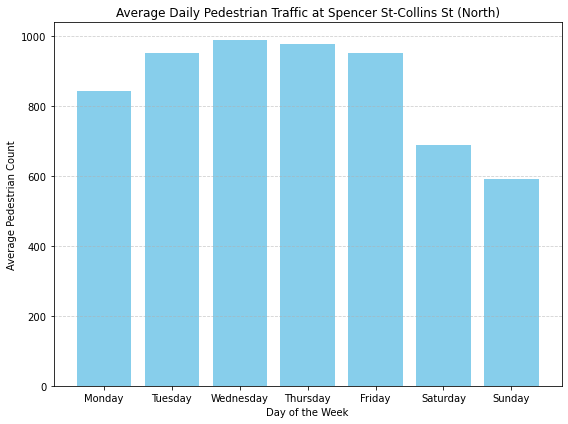

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.bar(weekly_avg_df['Day'], weekly_avg_df['Avg_Daily_Count'], color='skyblue')

plt.title('Average Daily Pedestrian Traffic at Spencer St-Collins St (North)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Pedestrian Count')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Spencer St-Collins St (North): There is a significant difference in footfall between weekdays and weekends, indicating that the area is primarily used for weekday commercial and office activity.


#### Search for the average daily foot traffic of sensor at Princes Bridge for one week from 2023 to 2024

In [42]:
query_weekly_avg = """
SELECT Day, AVG(Hourly_Counts) AS Avg_Daily_Count
FROM (
    SELECT Day, Hourly_Counts FROM 2023_PedSensor WHERE Sensor_Description = 'Princes Bridge'
    UNION ALL
    SELECT Day, Hourly_Counts FROM 2024_PedSensor WHERE Sensor_Description = 'Princes Bridge'
) AS combined_data
GROUP BY Day
ORDER BY 
    CASE 
        WHEN Day = 'Monday' THEN 1
        WHEN Day = 'Tuesday' THEN 2
        WHEN Day = 'Wednesday' THEN 3
        WHEN Day = 'Thursday' THEN 4
        WHEN Day = 'Friday' THEN 5
        WHEN Day = 'Saturday' THEN 6
        WHEN Day = 'Sunday' THEN 7
    END
"""

weekly_avg_df = spark.sql(query_weekly_avg).toPandas()


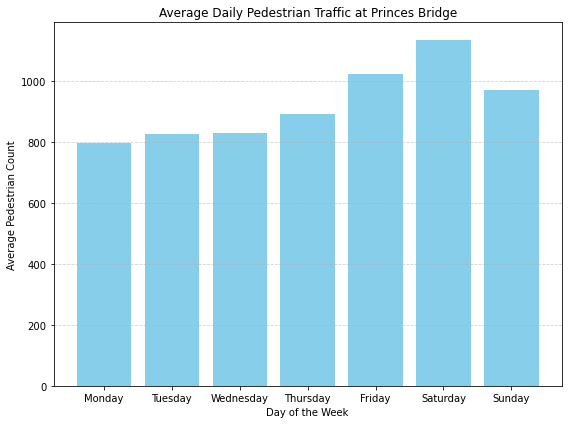

In [43]:

plt.figure(figsize=(8, 6))
plt.bar(weekly_avg_df['Day'], weekly_avg_df['Avg_Daily_Count'], color='skyblue')
plt.title('Average Daily Pedestrian Traffic at Princes Bridge')
plt.xlabel('Day of the Week')
plt.ylabel('Average Pedestrian Count')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Princes Bridge: As a tourist attraction and an important bridge connecting the city, the weekend rush shows its appeal is not just limited to the commuter crowd.

Search for the average daily foot traffic of sensor at Bourke Street Mall (North) for one week from 2023 to 2024

In [44]:
query_weekly_avg = """
SELECT Day, AVG(Hourly_Counts) AS Avg_Daily_Count
FROM (
    SELECT Day, Hourly_Counts FROM 2023_PedSensor WHERE Sensor_Description = 'Bourke Street Mall (North)'
    UNION ALL
    SELECT Day, Hourly_Counts FROM 2024_PedSensor WHERE Sensor_Description = 'Bourke Street Mall (North)'
) AS combined_data
GROUP BY Day
ORDER BY 
    CASE 
        WHEN Day = 'Monday' THEN 1
        WHEN Day = 'Tuesday' THEN 2
        WHEN Day = 'Wednesday' THEN 3
        WHEN Day = 'Thursday' THEN 4
        WHEN Day = 'Friday' THEN 5
        WHEN Day = 'Saturday' THEN 6
        WHEN Day = 'Sunday' THEN 7
    END
"""

weekly_avg_df = spark.sql(query_weekly_avg).toPandas()


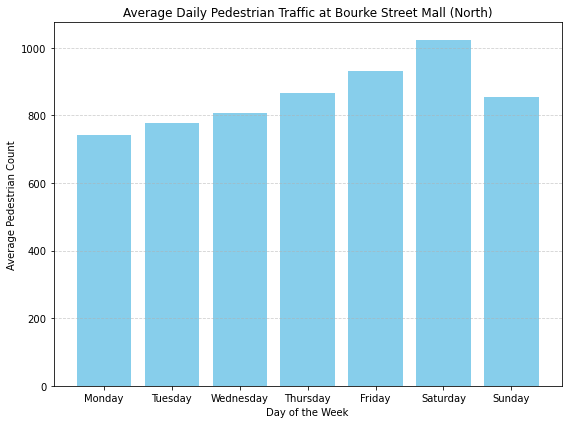

In [46]:
plt.figure(figsize=(8, 6))
plt.bar(weekly_avg_df['Day'], weekly_avg_df['Avg_Daily_Count'], color='skyblue')
plt.title('Average Daily Pedestrian Traffic at Bourke Street Mall (North)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Pedestrian Count')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Bourke Street Mall (North): Peaks on both weekdays and weekends, but especially on Saturdays, reflecting its appeal as a shopping centre.

Conclusion：Flinders Street Station Underpass and Spencer St-Collins St (North) have relatively higher footfalls on weekdays, especially the former's relatively stable and high footfalls from Monday to Friday. Both locations are close to transportation hubs and office areas, making them typical commuter hotspots.
Princes Bridge and Bourke Street Mall (North) show obvious weekend peak characteristics. In particular, Bourke Street Mall’s passenger flow reaches its peak on Saturday, showing its characteristics as a shopping area and tourist hotspot.

### 2.6 Analysis of pedestrian traffic for different sensors on a single day of the week for a whole day

#### 1.Sensor's average hourly traffic distribution at Flinders Street Station Underpass on Wednesday for the entire day

In [47]:
query_hourly_avg_saturday = """
SELECT Time, AVG(Hourly_Counts) AS Avg_Hourly_Count
FROM (
    SELECT Time, Hourly_Counts FROM 2023_PedSensor 
    WHERE Sensor_Description = 'Flinders Street Station Underpass' AND Day = 'Thursday'
    UNION ALL
    SELECT Time, Hourly_Counts FROM 2024_PedSensor 
    WHERE Sensor_Description = 'Flinders Street Station Underpass' AND Day = 'Thursday'
) AS combined_data
GROUP BY Time
ORDER BY Time
"""

hourly_avg_saturday_df = spark.sql(query_hourly_avg_saturday).toPandas()


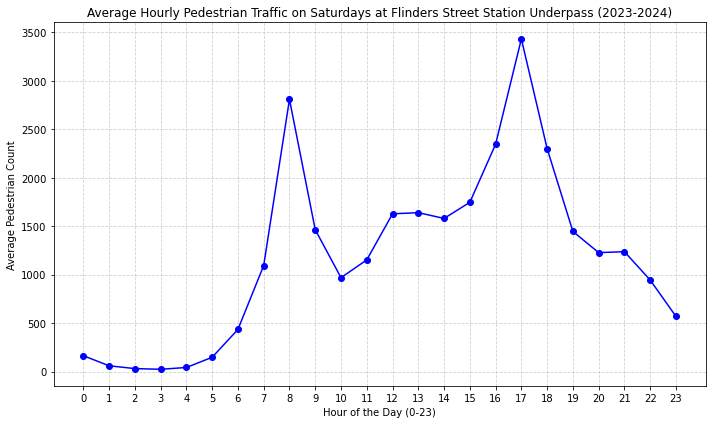

In [48]:

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_saturday_df['Time'], hourly_avg_saturday_df['Avg_Hourly_Count'], marker='o', linestyle='-', color='blue')
plt.title('Average Hourly Pedestrian Traffic on Thursday at Flinders Street Station Underpass (2023-2024)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Pedestrian Count')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Morning Peak (7:00 - 8:00): The graph shows a clear peak between 7:00 and 8:00 am, with nearly 3,000 people. This reflects travel trends among weekday morning peak commuters, with many using Flinders Street Station. As one of Melbourne's major transportation hubs, it is undoubtedly a key node for commuter traffic.
Afternoon peak (17:00 - 18:00): A larger peak occurs around 5 pm, which corresponds to the after-get off work commute peak. The afternoon peak on weekdays indicates that many people pass through the location after get off work, perhaps heading to other locations, home, or to social events.

#### 2.Sensor's average hourly traffic distribution at FSpencer St-Collins St (North) on Thuesday for the entire day

In [49]:
query_hourly_avg_saturday = """
SELECT Time, AVG(Hourly_Counts) AS Avg_Hourly_Count
FROM (
    SELECT Time, Hourly_Counts FROM 2023_PedSensor 
    WHERE Sensor_Description = 'Spencer St-Collins St (North)' AND Day = 'Tuesday'
    UNION ALL
    SELECT Time, Hourly_Counts FROM 2024_PedSensor 
    WHERE Sensor_Description = 'Spencer St-Collins St (North)' AND Day = 'Tuesday'
) AS combined_data
GROUP BY Time
ORDER BY Time
"""

hourly_avg_saturday_df = spark.sql(query_hourly_avg_saturday).toPandas()


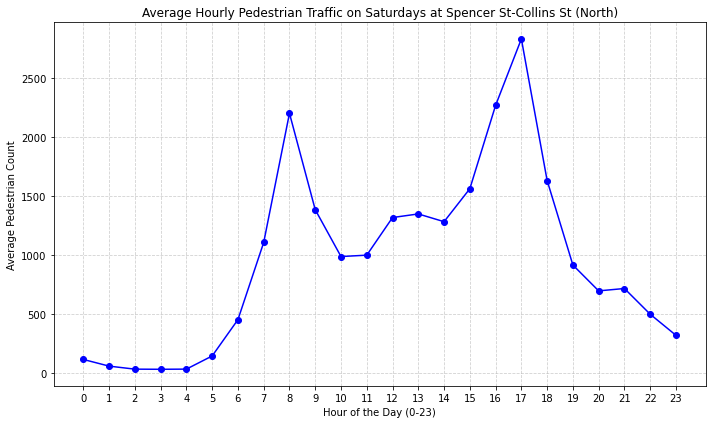

In [50]:

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_saturday_df['Time'], hourly_avg_saturday_df['Avg_Hourly_Count'], marker='o', linestyle='-', color='blue')
plt.title('Average Hourly Pedestrian Traffic on Tuesday at Spencer St-Collins St (North)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Pedestrian Count')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Morning Peak (7:00 - 8:00): There is also a significant peak around 7am on Tuesday morning with nearly 2500 people indicating this is an important commuting route. The location is close to Southern Cross Station and as a transport hub it attracts a large number of commuters in the morning.
Afternoon Peak (17:00 - 18:00): Again, there is another peak around 5pm. This trend shows a strong weekday peak pattern, further validating the importance of commuting activity here.

#### 3.Sensor's average hourly traffic distribution at Princes Bridge on Saturday for the entire day

In [51]:
query_hourly_avg_saturday = """
SELECT Time, AVG(Hourly_Counts) AS Avg_Hourly_Count
FROM (
    SELECT Time, Hourly_Counts FROM 2023_PedSensor 
    WHERE Sensor_Description = 'Princes Bridge' AND Day = 'Saturday'
    UNION ALL
    SELECT Time, Hourly_Counts FROM 2024_PedSensor 
    WHERE Sensor_Description = 'Princes Bridge' AND Day = 'Saturday'
) AS combined_data
GROUP BY Time
ORDER BY Time
"""

hourly_avg_saturday_df = spark.sql(query_hourly_avg_saturday).toPandas()


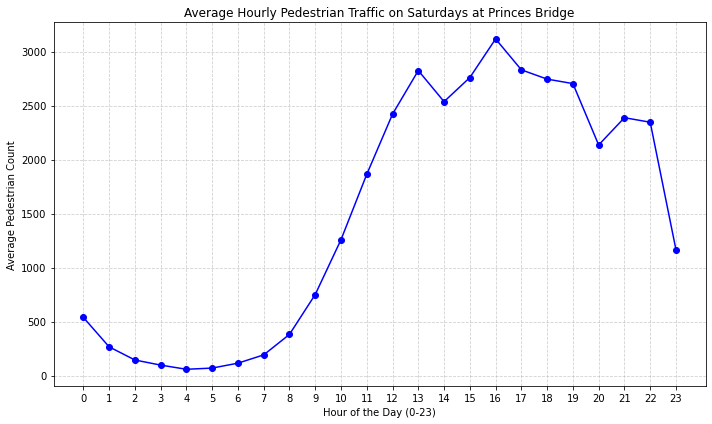

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_saturday_df['Time'], hourly_avg_saturday_df['Avg_Hourly_Count'], marker='o', linestyle='-', color='blue')
plt.title('Average Hourly Pedestrian Traffic on Saturday at Princes Bridge')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Pedestrian Count')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Gradual rising trend during the day (9:00 - 16:00): Unlike the commuter peaks at Flinders Street Station and Spencer St-Collins St, the Princes Bridge pattern on Saturday is gradually rising from 9am to 12pm to peak at 4 p.m. This suggests that the location serves primarily as a thoroughfare for tourists and local residents to get out and about on weekends.
Afternoon peak (13:00 - 16:00): The afternoon peak number is close to 3,000 people, indicating that the bridge, as an important walking path connecting downtown Melbourne to the Southbank Arts Center and waterfront area, attracts a large number of people on weekends. Whether shopping, sightseeing or participating in cultural activities, they are all important factors in attracting tourists.

#### 4.Sensor's average hourly traffic distribution at Bourke Street Mall (North) on Saturday for the entire day

In [53]:
query_hourly_avg_saturday = """
SELECT Time, AVG(Hourly_Counts) AS Avg_Hourly_Count
FROM (
    SELECT Time, Hourly_Counts FROM 2023_PedSensor 
    WHERE Sensor_Description = 'Bourke Street Mall (North)' AND Day = 'Saturday'
    UNION ALL
    SELECT Time, Hourly_Counts FROM 2024_PedSensor 
    WHERE Sensor_Description = 'Bourke Street Mall (North)' AND Day = 'Saturday'
) AS combined_data
GROUP BY Time
ORDER BY Time
"""

hourly_avg_saturday_df = spark.sql(query_hourly_avg_saturday).toPandas()


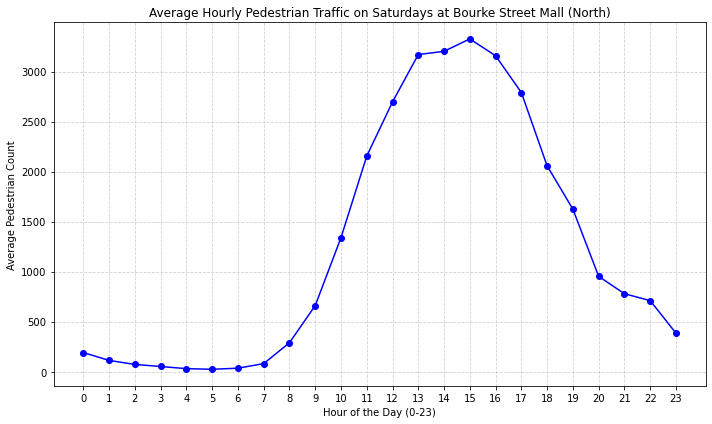

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_saturday_df['Time'], hourly_avg_saturday_df['Avg_Hourly_Count'], marker='o', linestyle='-', color='blue')
plt.title('Average Hourly Pedestrian Traffic on Saturdays at Bourke Street Mall (North)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Pedestrian Count')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Midday to afternoon shopping peak (14:00 - 15:00): Footfall patterns at Bourke Street Mall indicate a typical peak shopping period of close to 3,500 people on Saturday between 2pm and 3pm. Many people will choose to go to the city center shopping area on Saturday for consumption, dining or leisure and entertainment activities.
Smooth nighttime decrease: After the peak, ridership gradually decreases until it remains at a relatively low level in the evening. Similar to Princes Bridge.